In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from math import log,e,sqrt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Math

# 1 Measuring peakiness

We want to look at the 'peakiness' of the distribution of PMI values for a given word.  Given a PMI matrix, where each row corresponds the the PMI of a given word with all the other words in the sentence, define peakiness as a function of a row of PMI values. $\text{peakiness}: \mathbb R^d \to \mathbb{R}[0,1]$


## 1.1 Peakiness based on entropy
One intuitive measure is to make a length-dependent version of (inverse) entropy:
$$
\text{peakiness}(v) 
= 1 - \frac{S(v) }{ \log(d) }
$$
where 
$$
S(v) = -\sum_{i \in v} 
\frac i {\sum_{j \in v} j} \log(\frac i {\sum_{j \in v} j}),
$$
the entropy of the row, normalized, treated as a probability vector.

In [2]:
def entropy(vec, base=None):
    """ Computes entropy of unnormalized vector of floats. """
    total = sum(vec)
    probs = [i / total for i in vec]
    entropy = 0.
    base = e if base is None else base
    for p in probs:
        if p < 0:
            ent_p = np.inf
        elif p == 0:
            ent_p = 0.
        else:
            ent_p = p * log(p, base)
        entropy -= ent_p

    return entropy

In [399]:
# examples
def peakiness_entropy(vec, absolute=False):
    if len(vec) <= 1:
        return np.nan
    if absolute:
        vec = [abs(x) for x in vec]
    return 1 - entropy(vec) / log(len(vec))

# show examples
examples = ([1,0,0,0],[0,0,1,1],[0,0,10,10],[0,1,1,3],[1,1,1,1],
            [1,1,1,-1],[1],[0],[],
            [0,1,1],[0,1,1,0,0],[0,1,1,0,0,0,0,0,0])

display(Math(r"\text{peakiness_entropy}: \mathbb{R}^d \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

One issue, however, if we are going to treat a sequence of PMI scores as a probability vector, is that PMI may be negative.  An intuitive way to do this still eludes me.  Shifting the values by the minimum value will not preserve the intuitive peakiness (for instance, taking $[0,0,0,-2]$ to $[2,2,2,0]$ becomes much 'flatter' than it should).  Taking the absolute value is better, but also doesn't seem right, since the distinction between positive and negative is meaningful (in taking $[0,0,1,-1]$ to $[0,0,1,1]$, we lose the information that the penultimate position has the maximum PMI).

So, with absolute value:

In [400]:
# examples with abs
display(Math(r"\text{peakiness_entropy_abs}: \mathbb{R}^d \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec, absolute=True)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


## 1.2 Peakiness as "sparseness"

Another option, is 'sparseness' defined as a relationship between the $L_1$ and $L_2$ norms of a vector, $\text{sparseness}: \mathbb R^d \to \mathbb R[0,1]$.

$$
\text{sparseness}(v) = \frac
    {\left({\sqrt{d} - \dfrac{\|v\|_{L_1}}{\|v\|_{L_2}} }\right)}
    {\left({\sqrt{d}-1}\right)}
$$
from [Hoyer 2004](http://www.jmlr.org/papers/volume5/hoyer04a/hoyer04a.pdf) (§3.1)

In [401]:
def peakiness_sparseness(vec):
    d = len(vec)
    if d <= 1:
        return np.nan
    l1 = sum(abs(x) for x in vec)
    l2 = sqrt(sum(x**2 for x in vec))
    numerator = sqrt(d) - l1 / l2
    return numerator / (sqrt(d) - 1)

# examples
display(Math(r"\text{peakiness_sparseness}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_sparseness(pmi_vec)}"))
    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [411]:
# we could go farther, and get the difference between the L_1 and L_\infty norms.  
# This will give higher peakiness in general.

def peakiness_supersparseness(vec):
    d = len(vec)
    if d <= 1:
        return np.nan
    l1 = sum(abs(x) for x in vec)
    linf = max(abs(x) for x in vec)
    numerator = d - l1 / linf
    return numerator / (d - 1)

# examples
display(Math(r"\text{peakiness_supersparseness}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_supersparseness(pmi_vec)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

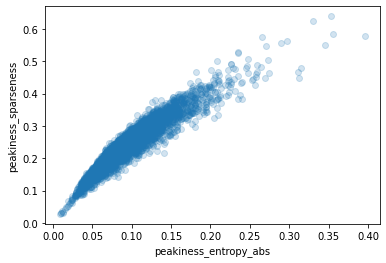

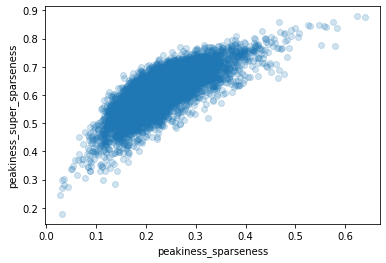

In [416]:
# comparing two measures

pairs = []
pairs2 = []
for i in range(500):
    # get a fake pmi matrix: 
    # a random square matrix size 5 to 30, populated with values in [-7,7]
    d = np.random.randint(25)+5
    pmis = 14 * np.random.sample((d,d)) - 7
    pmis = pmis + np.transpose(pmis) # symmetrize
    sparseness = np.apply_along_axis(peakiness_sparseness, axis=1, arr=pmis)
    supersparseness = np.apply_along_axis(peakiness_supersparseness, axis=1, arr=pmis)
    entropy_abs = np.apply_along_axis(peakiness_entropy, axis=1, arr=pmis, absolute=True)
    pairs += list(zip(entropy_abs,sparseness))
    pairs2 += list(zip(sparseness,supersparseness))

plt.scatter(*zip(*pairs),alpha = 0.2)
plt.xlabel('peakiness_entropy_abs')
plt.ylabel('peakiness_sparseness')
plt.show()

plt.scatter(*zip(*pairs2),alpha = 0.2)
plt.xlabel('peakiness_sparseness')
plt.ylabel('peakiness_super_sparseness')
plt.show()

The for vectors in the middle range, 'entropy_abs' measure is generally a bit lower than 'sparseness', but they're probably going to be similar, pracically.

In [18]:
# some examples
RESULTS_DIR = "results-clean/bert-base-cased_pad30_2020-07-27-14-01/" 
matrices_npz = np.load(os.path.join(RESULTS_DIR, 'pmi_matrices.npz'))
logliks_npz = np.load(os.path.join(RESULTS_DIR, 'pseudo_logliks.npz'))

scores_path = glob.glob(RESULTS_DIR+'scores*.csv')[0]
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*.csv')[0]
wordpair = pd.read_csv(wordpair_path)
scores = pd.read_csv(scores_path)

count=0
for sentence, matrix in matrices_npz.items():
    sent = sentence.split(' ')
    if 4 < len(sent) < 8:
        print(f'sentence {sent[0]}\n\tsparseness\tentropy_abs')
        matrix = matrix + np.transpose(matrix) # symmetrize
        for i, row in enumerate(matrix):
            row = row[np.arange(len(row))!=i] # remove diagonal
            print(f'\t{peakiness_sparseness(row):.6f}\t{peakiness_entropy(row, absolute=True):.6f}\t{sent[i+1]}')
        print()
        count+=1
        if count > 3:
            break

sentence 66
	sparseness	entropy_abs
	0.831714	0.607264	Ad
	0.722654	0.462492	Notes
	0.862006	0.658110	...
	0.816845	0.588180	.

sentence 69
	sparseness	entropy_abs
	0.419851	0.259570	Terms
	0.532268	0.349299	were
	0.618737	0.380416	n't
	0.272664	0.192839	disclosed
	0.371169	0.196617	.

sentence 102
	sparseness	entropy_abs
	0.486585	0.342947	I
	0.307110	0.196478	love
	0.278814	0.173035	'em
	0.470282	0.303258	both
	0.280670	0.195996	.

sentence 123
	sparseness	entropy_abs
	0.472148	0.253109	``
	0.370721	0.239386	That
	0.598013	0.365140	's
	0.601619	0.400653	baseball
	0.400749	0.228239	.



# 2 Correlation of peakiness with dependency accuracy

## 2.1 Mean peakiness vs undirected accuracy score

First, does mean peakiness over all words in a sentence correlate with sentence-wide accuracy UUAS = num correct / total edges ?

In [395]:
# !run cell at bottom to get observations first
av_sparseness = []
av_supersparseness = []
av_entropyabs = []
for i, obs in enumerate(tqdm(OBSERVATIONS)):
    sentence = str(' '.join([str(i), *obs.sentence]))
    matrix = matrices_npz[sentence]
    pseudo_loglik = logliks_npz[sentence]
    
    matrix = matrix + np.transpose(matrix) # symmetrize
    sparseness = np.apply_along_axis(peakiness_sparseness, axis=1, arr=matrix)
    supersparseness = np.apply_along_axis(peakiness_super_sparseness, axis=1, arr=matrix)
    entropyabs = np.apply_along_axis(peakiness_entropy, axis=1, arr=matrix, absolute=True)
    av_sparseness.append(np.mean(sparseness))
    av_supersparseness.append(np.mean(supersparseness))
    av_entropyabs.append(np.mean(entropyabs))

scores["av_sparseness"] = av_sparseness
scores["av_supersparseness"] = av_supersparseness
scores["av_entropyabs"] = av_entropyabs

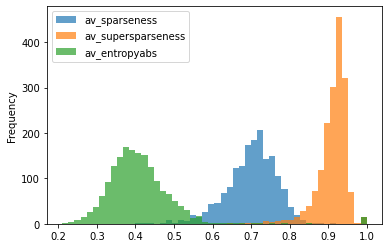

In [434]:
scores[['av_sparseness','av_supersparseness','av_entropyabs']].plot.hist(alpha=0.7,bins=50)
plt.show()

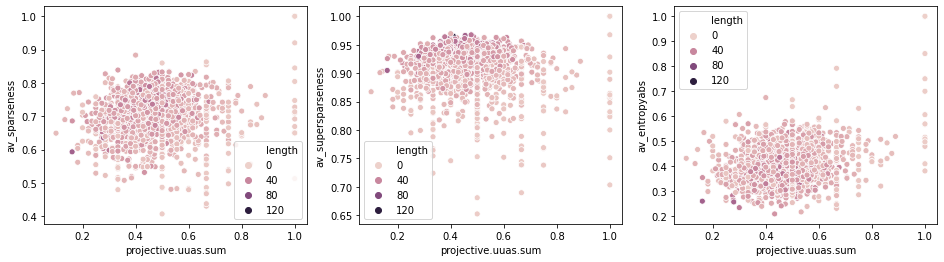

In [417]:
scores['length'] = scores['sentence_length'].astype(float)
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
sns.scatterplot(x='projective.uuas.sum', y='av_sparseness', hue='length',
                 data=scores, ax=axs[0])
sns.scatterplot(x='projective.uuas.sum', y='av_supersparseness', hue='length',
                 data=scores, ax=axs[1])
sns.scatterplot(x='projective.uuas.sum', y='av_entropyabs', hue='length',
                 data=scores, ax=axs[2])
plt.show()

It doesn't look correlated.

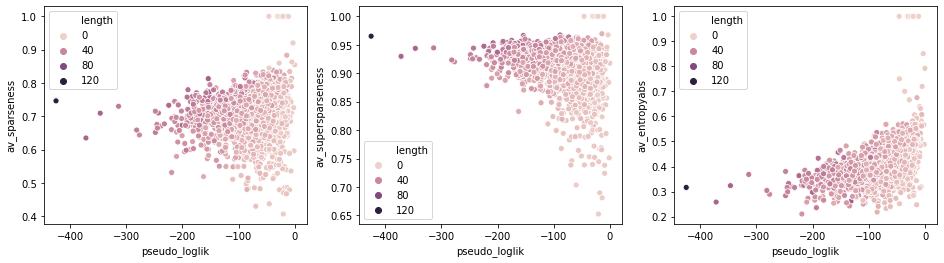

In [419]:
# just out of curiosity, does peakiness correlate with log likelihood? 
# this would be true if sentences which the model predicted very confidently
# it also predicted very markov-ly
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
sns.scatterplot(x='pseudo_loglik', y='av_sparseness', hue='length',
                 data=scores, ax=axs[0])
sns.scatterplot(x='pseudo_loglik', y='av_supersparseness', hue='length',
                 data=scores, ax=axs[1])
sns.scatterplot(x='pseudo_loglik', y='av_entropyabs', hue='length',
                 data=scores, ax=axs[2])
# fig.colorbar(fig)
plt.show()

## Per word

For a given word, does the peakiness of the row of CPMIs for that word with all other words in the sentence correlate with the correctness of its prediction?
That is, in a CPMI matrix, are the max values per row more likely to correspond to gold dependencies when the peakiness is high?

In [320]:
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*')[0]
wordpair = pd.read_csv(wordpair_path,dtype={'sentence_index': 'int'})

In [323]:
def insert_nan_diagonal(triu, tril):
    assert triu.shape==tril.shape
    d = triu.shape[0]
    upper = np.zeros((d+1,d+1))
    upper[:-1,1:] = triu
    lower = np.zeros((d+1,d+1))
    lower[1:,:-1] = tril
    matrix = np.nansum(np.dstack((upper, lower)),2)
    np.fill_diagonal(matrix,np.NaN) # should ignore diagonal
    return matrix

def max_is_gold(pmi_row,gold_row):
    assert len(pmi_row)==len(gold_row)
    return bool(gold_row[np.argmax(pmi_row)])

In [342]:
# an example.  dev sentence #31:
idx=31
print(f"Sentence {idx}:",
      f"{int(scores.sentence_length[idx])} PTB tokens;",
      f"{scores.number_edges[idx]-1} words; {scores.number_edges[idx]} edges")
print(OBSERVATIONS[idx].sentence)
df_idx = pd.DataFrame(wordpair[(wordpair.sentence_index==idx)])
print("Between PTB tokens, the following (absolute value) cpmis:")
df_idx['pmi_sum_abs'] = abs(df_idx['pmi_tril']) + abs(df_idx['pmi_triu'])
print(df_idx.pivot_table(index='i1', columns='i2', values='pmi_sum_abs'))

triu = df_idx.pivot_table(index='i1', columns='i2', values='pmi_triu').to_numpy()
tril = df_idx.pivot_table(index='i1', columns='i2', values='pmi_tril').to_numpy().T
matrix = insert_nan_diagonal(triu, tril)
matrix = abs(np.nansum(np.dstack((matrix, np.transpose(matrix))),2)) # symmetrize and absolute value
np.fill_diagonal(matrix,np.NaN) # should ignore diagonal
print(f"symmetrized absolute valued matrix:\n{matrix}")

# The is_gold matrix shows which edges correspond to gold edges
df_idx_is_gold = df_idx.pivot_table(index='i1', columns='i2', values='gold_edge')
print(df_idx_is_gold)
matrix_is_gold = df_idx_is_gold.to_numpy()
matrix_is_gold = insert_nan_diagonal(matrix_is_gold,matrix_is_gold.T)
print(f"symmetrized is gold:\n{matrix_is_gold}\n")

print(f'{idx}\tword\tsparseness\tentropy_abs\tmax==gold')
for i, row in enumerate(np.hstack((matrix,matrix_is_gold))):
    pmi_row, gold_row = np.split(row,2)
    pmi_row = pmi_row[np.arange(len(pmi_row))!=i] # remove diagonal entries
    gold_row = gold_row[np.arange(len(gold_row))!=i]
    print(f'\t{OBSERVATIONS[idx].sentence[i+1]}',
          f'\t{peakiness_sparseness(pmi_row):.6f}',
          f'\t{peakiness_entropy(pmi_row, absolute=True):.6f}',
          f'\t{max_is_gold(pmi_row,gold_row)}',
          sep='')

Sentence 31: 8 PTB tokens; 4 words; 5 edges
('This', 'time', ',', 'the', 'firms', 'were', 'ready', '.')
Between PTB tokens, the following (absolute value) cpmis:
i2         1         3         4         5         6
i1                                                  
0   6.861337  0.098382  0.164262  0.042397  0.042637
1        NaN  0.048580  0.176313  0.010752  0.173793
3        NaN       NaN  0.264474  0.019385  0.165534
4        NaN       NaN       NaN  3.857900  0.904106
5        NaN       NaN       NaN       NaN  3.005481
symmetrized absolute valued matrix:
[[          nan 6.8613372e+00 9.8382000e-02 1.6426180e-01 4.2396600e-02
  1.5430900e-02]
 [6.8613372e+00           nan 4.8580200e-02 1.7484100e-01 7.0770000e-04
  1.2828780e-01]
 [9.8382000e-02 4.8580200e-02           nan 2.6447390e-01 1.6005500e-02
  1.6553410e-01]
 [1.6426180e-01 1.7484100e-01 2.6447390e-01           nan 3.8578997e+00
  9.0410620e-01]
 [4.2396600e-02 7.0770000e-04 1.6005500e-02 3.8578997e+00           nan
  3

In [464]:
def compare_peakines_accuracy(observations, wordpair):
    scores_list = []
    for idx, observation in tqdm(enumerate(observations)):
        df_idx = pd.DataFrame(wordpair[(wordpair.sentence_index==idx)])
        df_idx['pmi_sum_abs'] = abs(df_idx['pmi_tril']) + abs(df_idx['pmi_triu'])

        triu = df_idx.pivot_table(index='i1', columns='i2', values='pmi_triu').to_numpy()
        tril = df_idx.pivot_table(index='i1', columns='i2', values='pmi_tril').to_numpy().T
        matrix = insert_nan_diagonal(triu, tril)
        matrix = abs(np.nansum(np.dstack((matrix, np.transpose(matrix))),2)) # symmetrize and absolute value
        np.fill_diagonal(matrix,np.NaN) # should ignore diagonal

        # The is_gold matrix shows which edges correspond to gold edges
        df_idx_is_gold = df_idx.pivot_table(index='i1', columns='i2', values='gold_edge')
        matrix_is_gold = df_idx_is_gold.to_numpy()
        matrix_is_gold = insert_nan_diagonal(matrix_is_gold,matrix_is_gold.T)
        
        indices = set(df_idx.i1.unique()).union(df_idx.i2.unique())
        sentence_words = [OBSERVATIONS[idx].sentence[i] for i in indices]
        
        for i, row in enumerate(np.hstack((matrix,matrix_is_gold))):
            scores= {}
            pmi_row, gold_row = np.split(row,2)
            pmi_row = pmi_row[np.arange(len(pmi_row))!=i] # remove diagonal entries
            gold_row = gold_row[np.arange(len(gold_row))!=i]
            scores['sentence_index'] = idx
            scores['word'] = sentence_words[i]
            scores['peakiness_sparseness'] = peakiness_sparseness(pmi_row)
            scores['peakiness_entropyabs'] = peakiness_entropy(pmi_row, absolute=True)
            scores['max_is_gold'] = max_is_gold(pmi_row,gold_row)
            scores_list.append(scores)
    return scores_list

peakiness_scores = pd.DataFrame(
    compare_peakines_accuracy(OBSERVATIONS[:60], wordpair))

In [467]:
peakiness_scores[peakiness_scores.sentence_index==31]

,sentence_index,word,peakiness_sparseness,peakiness_entropyabs,max_is_gold
686,31,This,0.962561,0.855671,True
687,31,time,0.958893,0.848370,True
688,31,the,0.360233,0.181816,True
689,31,firms,0.717935,0.438362,False
690,31,were,0.663888,0.543788,False
691,31,ready,0.723953,0.487095,True


In [713]:
# fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
# sns.boxplot(x='max_is_gold', y='peakiness_sparseness', data=df, ax=axs[0])
# sns.boxplot(x='max_is_gold', y='peakiness_entropyabs', data=df, ax=axs[1])
# plt.show()

In [717]:
df = pd.DataFrame(peakiness_scores[["peakiness_entropyabs","peakiness_sparseness","max_is_gold"]])

def plot_peakiness_accuracy(sparseness_measure):
    f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, 
                                                 gridspec_kw={"height_ratios": (.1,.1,.8)},
                                                 figsize=(10, 5)) 
    vals = [True, False]
    colors = sns.color_palette("deep")
    ax_box = [ax_box1,ax_box2]

    for i in [0,1]:
        sns.boxplot(df[df["max_is_gold"]==vals[i]][sparseness_measure], color=colors[i], ax=ax_box[i])
        sns.distplot(
            df[df["max_is_gold"] == vals[i]][sparseness_measure], ax=ax_hist, bins=50, kde=True)

    # # Remove x axis name for the boxplot
    ax_box1.set(xlabel='argmax of row is gold = TRUE')
    ax_box2.set(xlabel='argmax of row is gold = FALSE')
    plt.show()

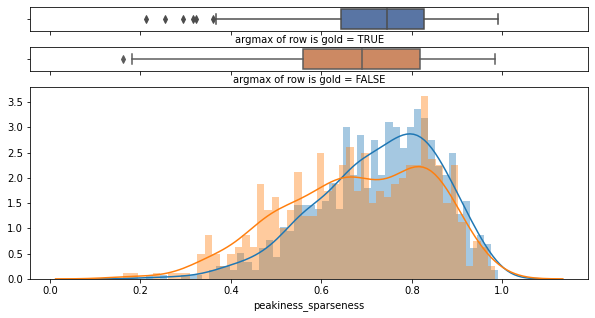

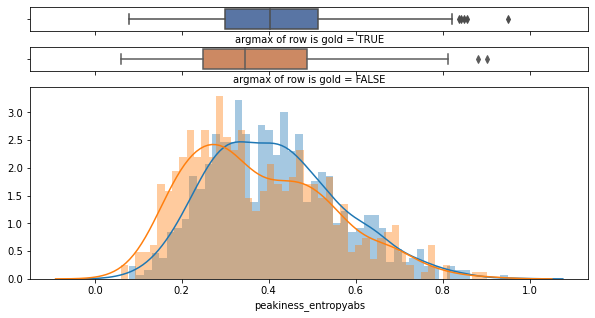

In [718]:
plot_peakiness_accuracy("peakiness_sparseness")
plot_peakiness_accuracy("peakiness_entropyabs")

In [716]:
# It's right about 60% of the time 
# (note, there are multiple potential edges from a single word, so this is not a good score)
len(df[df["max_is_gold"]==True])/len(df)

0.6050283860502839

# Extra stuff : reading data

In [20]:
from collections import namedtuple
class CONLLReader():
    def __init__(self, conll_cols, additional_field_name=None):
        if additional_field_name:
            conll_cols += [additional_field_name]
        self.conll_cols = conll_cols
        self.observation_class = namedtuple("Observation", conll_cols)
        self.additional_field_name = additional_field_name

    # Data input
    @staticmethod
    def generate_lines_for_sent(lines):
        '''Yields batches of lines describing a sentence in conllx.

        Args:
            lines: Each line of a conllx file.
        Yields:
            a list of lines describing a single sentence in conllx.
        '''
        buf = []
        for line in lines:
            if line.startswith('#'):
                continue
            if not line.strip():
                if buf:
                    yield buf
                    buf = []
                else:
                    continue
            else:
                buf.append(line.strip())
        if buf:
            yield buf

    def load_conll_dataset(self, filepath):
        '''Reads in a conllx file; generates Observation objects

        For each sentence in a conllx file, generates a single Observation
        object.

        Args:
            filepath: the filesystem path to the conll dataset
            observation_class: namedtuple for observations

        Returns:
        A list of Observations
        '''
        observations = []
        lines = (x for x in open(filepath))
        for buf in self.generate_lines_for_sent(lines):
            conllx_lines = []
            for line in buf:
                conllx_lines.append(line.strip().split('\t'))
            if self.additional_field_name:
                newfield = [None for x in range(len(conllx_lines))]
                observation = self.observation_class(
                    *zip(*conllx_lines), newfield)
            else:
                observation = self.observation_class(
                    *zip(*conllx_lines))
            observations.append(observation)
        return observations

CONLL_COLS = ['index',
              'sentence',
              'lemma_sentence',
              'upos_sentence',
              'xpos_sentence',
              'morph',
              'head_indices',
              'governance_relations',
              'secondary_relations',
              'extra_info']

OBSERVATIONS = CONLLReader(CONLL_COLS).load_conll_dataset(
    'ptb3-wsj-data/ptb3-wsj-dev.conllx')

Check for duplicate sentences.

In [21]:
from collections import defaultdict

def list_duplicates(triple):
    tally = defaultdict(list)
    for i,sent,_ in triple:
        tally[sent].append(i)
    return ((locs,key) for key,locs in tally.items() 
                            if len(locs)>1)

pd.DataFrame(
    list_duplicates(idx_sentence_matrix_triples),
    columns=['indices','sentence']).style.set_properties(
    **{'text-align': 'left', 'display.max_colwidth': -1}).set_table_styles(
    [ dict(selector='th', props=[('text-align', 'left')] ) ])

NameError: name 'idx_sentence_matrix_triples' is not defined